### Instructions

Refer to `Example script.ipynb` for examples of using this notebook.

In [13]:
#model_path = '/data00/projects/megameta/scripts/jupyter_megameta/l1analysis/smoking_UCLA/task-ads_model-beta.json'

In [1]:
try:
    if skip_l2 == True:
        skip_l2 = True
        
    if force == True:
        force = True

except:
    skip_l2 = False
    force = False

In [15]:
import os, glob, re, sys, json, copy  

import nipype.interfaces.io as nio           
import nipype.interfaces.spm as spm    
import nipype.interfaces.matlab as mlab     
import nipype.pipeline.engine as pe 
import nipype.interfaces.utility as util

import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as sio

from nilearn import plotting

In [16]:
def ensure_list(obj):
    if type(obj) is not list:
        return [obj]
    else:
        return obj

def copy_from_template(target, template):
    for key, item in template.items():
        if key not in target.keys():
            target[key] = copy.deepcopy(template[key])
        elif type(item) is dict:
            copy_from_template(target[key], template[key])

In [17]:
with open(model_path, 'r') as f:
    model = json.load(f)

for template_path in ensure_list(model.get("Template", [])):
    with open(template_path, 'r') as f:
        template = json.load(f)
    copy_from_template(model, template)
    
env = model['Environment']
job_name = 'task-{}_model-{}'.format(model['Info']['task'], model['Info']['model'])

In [18]:
mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(env["spm_path"])

In [19]:
con_path = os.path.join(env['output_path'], job_name, 'contrasts.csv')
print("Aggregating contrast files", end=" ")

if os.path.exists(con_path) and force == False:
    con_df = pd.read_csv(con_path)
    
else:
    con_df = []

    for sub_folder in glob.glob(os.path.join(env['output_path'], job_name, 'sub-*')):
        print("*",end="")
        
        if not os.path.isdir(sub_folder):
            continue

        sub = os.path.basename(sub_folder)

        spm_file = os.path.join(sub_folder, 'SPM.mat')
        if not os.path.exists(spm_file):
            continue

        spm_mat = sio.loadmat(spm_file, 
                   squeeze_me=True, struct_as_record=False)

        for n, con in enumerate(spm_mat['SPM'].xCon, start=1):
            con_file = os.path.join(sub_folder, f"con_{n:04d}.nii")
            if os.path.exists(con_file):
                con_df.append({'sub': sub,
                              'con': con.name,
                              'path': con_file})

    con_df = pd.DataFrame(con_df)
    con_df.to_csv(con_path, index=False)
    
print(" ")    
print(con_df.pivot_table(index='con', values='sub', aggfunc='count'))

Aggregating contrast files ********************************* 
                                   sub
con                                   
button_press                        33
pure_message_fant_Fantasy           33
pure_message_fant_Leap              33
pure_message_fant_Stalker           33
pure_message_finger_Break           33
pure_message_finger_Hello           33
pure_message_finger_Steve           33
pure_message_finger_Tomorrow        33
pure_message_relearn_Coffee         33
pure_message_relearn_Driving        33
pure_message_relearn_StartYourDay   33
pure_message_shs_Apartment          33
pure_message_shs_TakeitOutside      33
pure_message_shs_VictimWife         33
pure_message_test_Katrina           33
pure_message_test_Pam               33
pure_message_test_Reynaldo          33
rate                                33


In [12]:
con_df.query('sub=="sub-SMK02"')

,sub,con,path
18,sub-SMK02,pure_message_relearn_StartYourDay,/data00/projects/megameta/smoking_UCLA/derivat...
19,sub-SMK02,rate,/data00/projects/megameta/smoking_UCLA/derivat...
20,sub-SMK02,button_press,/data00/projects/megameta/smoking_UCLA/derivat...
21,sub-SMK02,pure_message_fant_Stalker,/data00/projects/megameta/smoking_UCLA/derivat...
22,sub-SMK02,pure_message_shs_TakeitOutside,/data00/projects/megameta/smoking_UCLA/derivat...
23,sub-SMK02,pure_message_shs_Reynaldo,/data00/projects/megameta/smoking_UCLA/derivat...
24,sub-SMK02,pure_message_finger_Tomorrow,/data00/projects/megameta/smoking_UCLA/derivat...
25,sub-SMK02,pure_message_fant_Leap,/data00/projects/megameta/smoking_UCLA/derivat...
26,sub-SMK02,pure_message_finger_Steve,/data00/projects/megameta/smoking_UCLA/derivat...
27,sub-SMK02,pure_message_relearn_Driving,/data00/projects/megameta/smoking_UCLA/derivat...


In [118]:
def get_contrast_files(contrast_name, contrast_df):
    return contrast_df.query(f'con == "{contrast_name}"').path.tolist()

In [119]:
l2analysis_path = os.path.join(env['output_path'], job_name, "l2analysis")

In [120]:
l2analysis = pe.Workflow(base_dir=os.path.join(env['working_path'], job_name), name='l2analysis')

infosource = pe.Node(util.IdentityInterface(fields=['contrast_name']),
                  name="infosource")
infosource.iterables = ('contrast_name', con_df.con.unique().tolist())

getcontrastfiles = pe.Node(util.Function(input_names=['contrast_name', 'contrast_df'],
                                        output_names=['contrast_files'],
                                        function=get_contrast_files),
                    name='getcontrastfiles')
getcontrastfiles.inputs.contrast_df = con_df

# One Sample T-Test Design - creates one sample T-Test Design
onesamplettestdes = pe.Node(spm.OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimate the parameters of the model
level2estimate = pe.Node(spm.EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates simple group contrast
level2conestimate = pe.Node(spm.EstimateContrast(group_contrast=True), 
                            name="level2conestimate")
cont = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont]

# Datasink - creates output folder for important outputs
datasink = pe.Node(nio.DataSink(base_directory=l2analysis_path), 
                   name="datasink")
datasink.inputs.substitutions = [('_contrast_name_', '')]

# Connect workflow
l2analysis.connect([(infosource, getcontrastfiles, [('contrast_name', 'contrast_name')]),
                    (getcontrastfiles, onesamplettestdes, [('contrast_files', 'in_files')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')] ),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '@spm_mat'),
                                                   ('spmT_images',
                                                    '@T'),
                                                   ('con_images',
                                                    '@con')])
                   ])

if not skip_l2:
    pipeline_graph = l2analysis.run()

210201-07:52:22,859 nipype.workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
210201-07:52:23,218 nipype.workflow INFO:
	 Running serially.
210201-07:52:23,220 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.getcontrastfiles" in "/fmriNASTest/data00/projects/megameta/darpa1/working/nipype/task-share_model-pmodSelect/l2analysis/_contrast_name_read_Readxselect_rank^1/getcontrastfiles".
210201-07:52:23,649 nipype.workflow INFO:
	 [Node] Running "getcontrastfiles" ("nipype.interfaces.utility.wrappers.Function")
210201-07:52:24,357 nipype.workflow INFO:
	 [Node] Finished "l2analysis.getcontrastfiles".
210201-07:52:24,359 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.onesampttestdes" in "/fmriNASTest/data00/projects/megameta/darpa1/working/nipype/task-share_model-pmodSelect/l2analysis/_contrast_name_read_Readxselect_rank^1/onesampttestdes".
210201-07:52:24,766 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interface

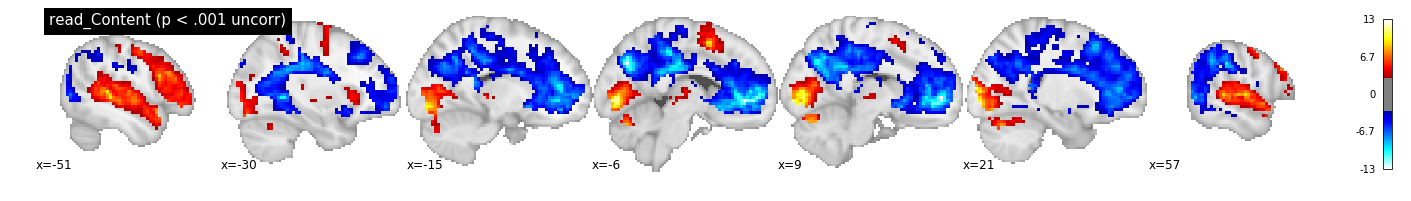

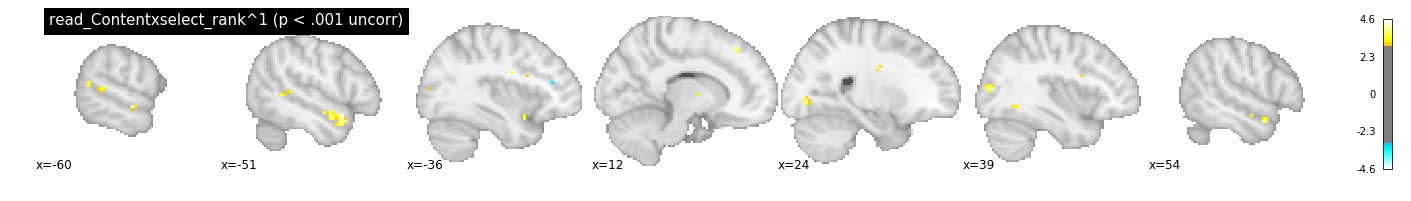

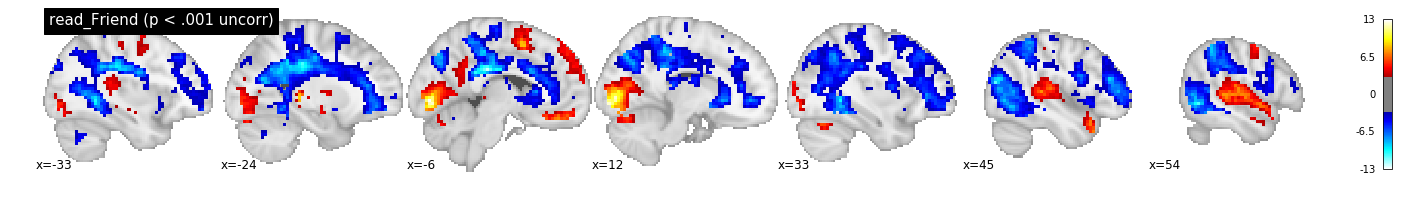

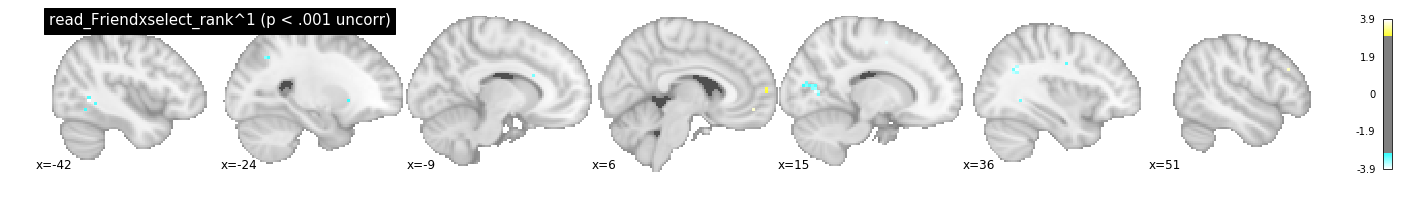

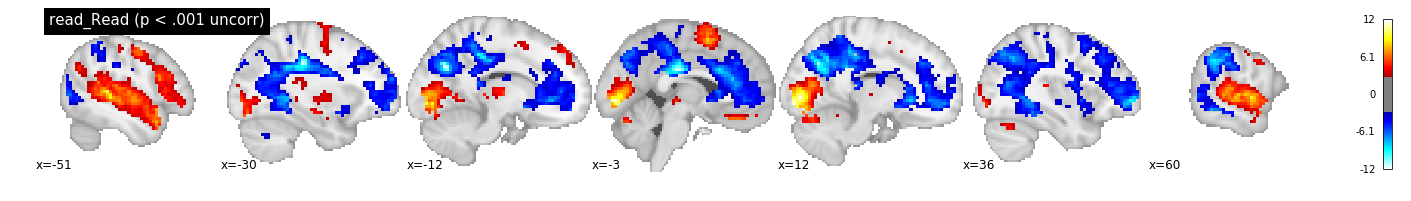

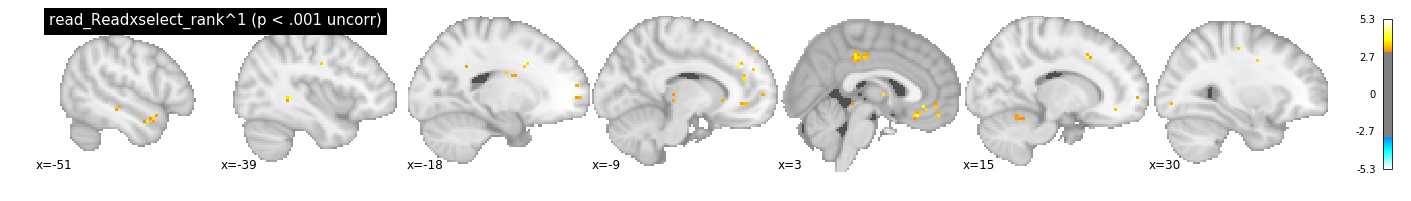

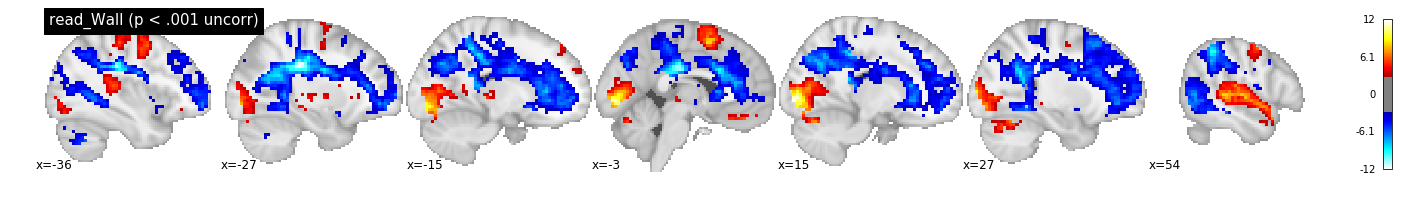

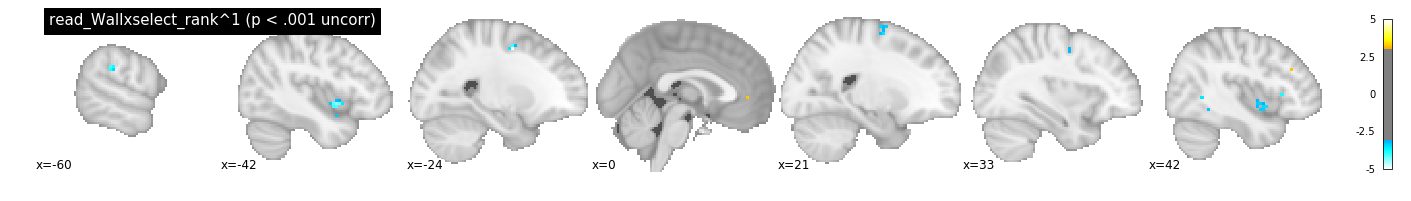

In [121]:
if not skip_l2:
    
    p_val = 0.001
    p001_uncorrected = sp.stats.norm.isf(p_val)

    for con_folder in glob.glob(os.path.join(l2analysis_path, "*")):
        if not os.path.isdir(con_folder):
            continue

        con_name = os.path.basename(con_folder)
        t_map = os.path.join(con_folder, "spmT_0001.nii")

        if not os.path.exists(t_map):
            continue

        plotting.plot_stat_map(
            t_map, threshold=p001_uncorrected, colorbar=True, display_mode='x',
            title=f'{con_name} (p < .001 uncorr)')

        plotting.show()

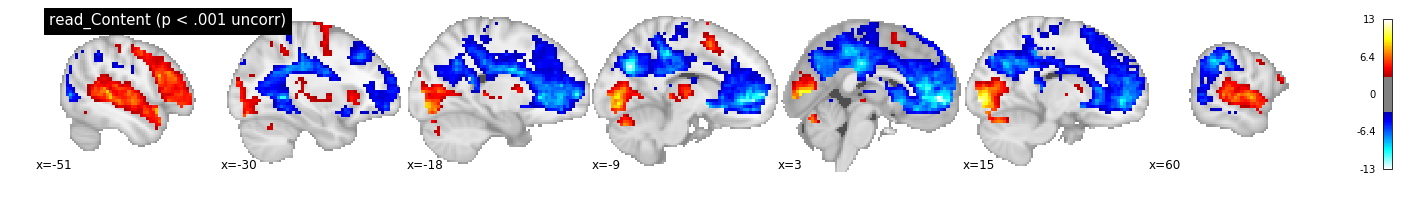

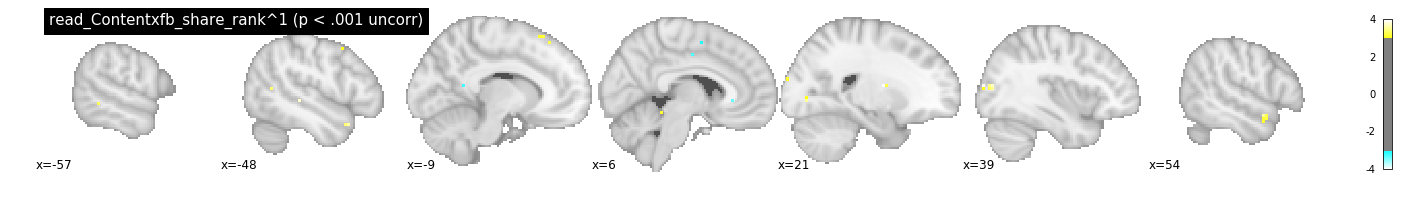

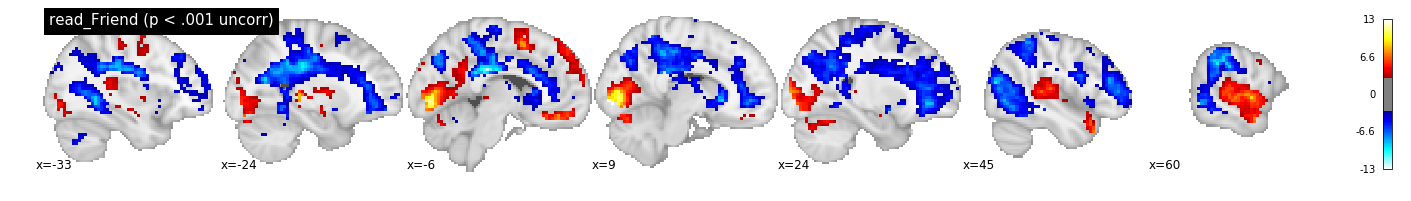

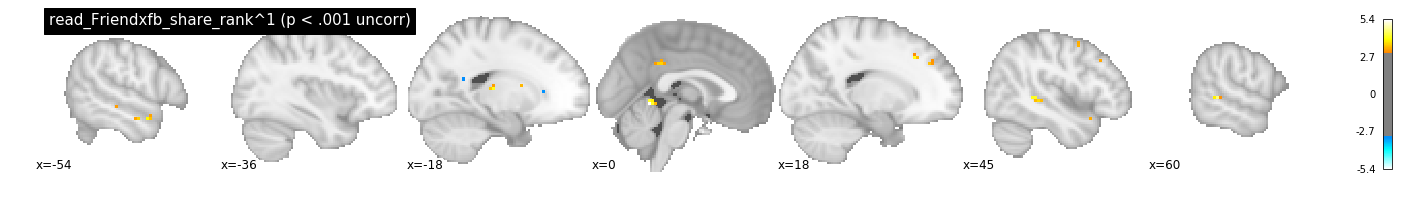

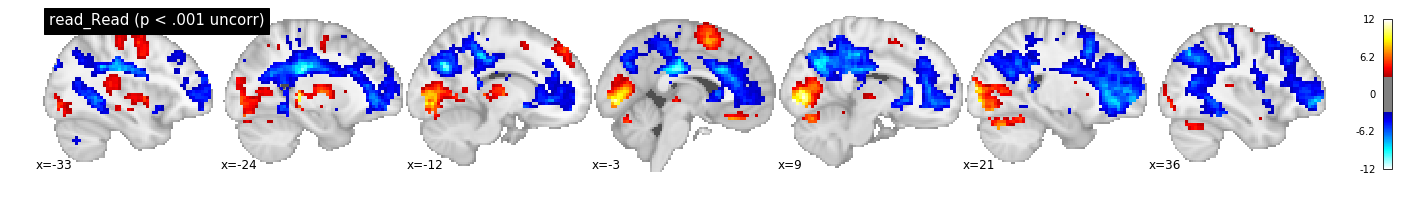

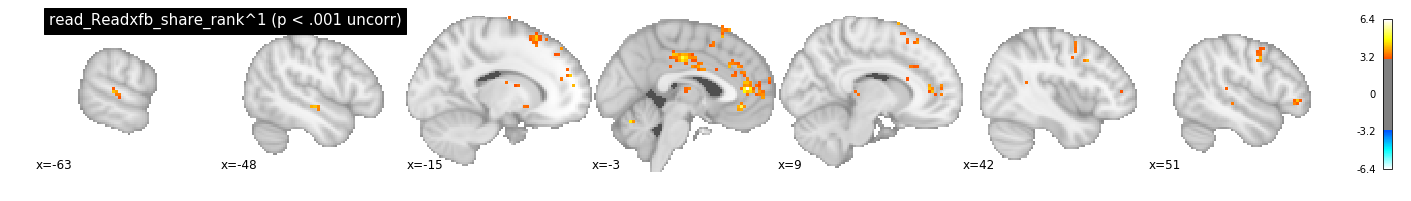

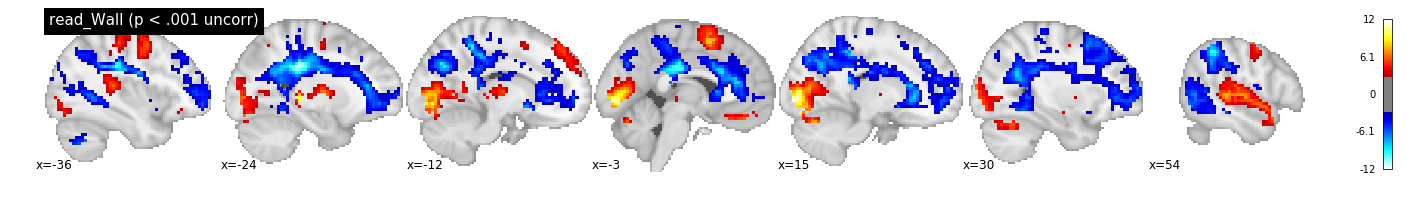

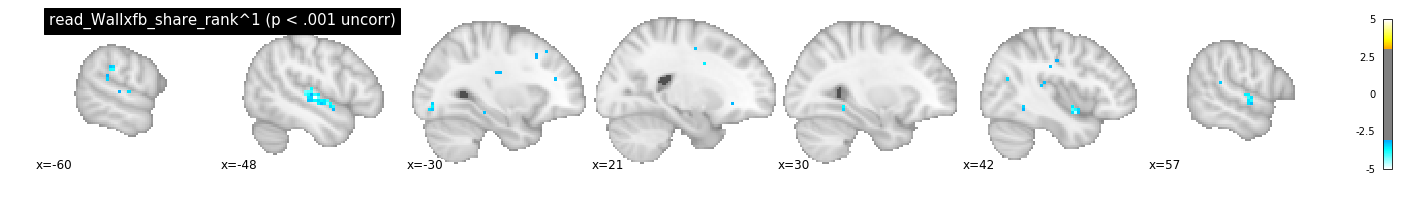

In [116]:
if not skip_l2:
    
    p_val = 0.001
    p001_uncorrected = sp.stats.norm.isf(p_val)

    for con_folder in glob.glob(os.path.join(l2analysis_path, "*")):
        if not os.path.isdir(con_folder):
            continue

        con_name = os.path.basename(con_folder)
        t_map = os.path.join(con_folder, "spmT_0001.nii")

        if not os.path.exists(t_map):
            continue

        plotting.plot_stat_map(
            t_map, threshold=p001_uncorrected, colorbar=True, display_mode='x',
            title=f'{con_name} (p < .001 uncorr)')

        plotting.show()